# Data preparation

What we do in this notebook:

* Read data from the Kaggle file `pairs.csv`.
* Take the subset of data with country label `US`.
* Unify the `state` code into two letter format using the state code file `state-code.csv`.
* Throw away "fake" rows with the `state` codes in `['UK', 'CE', 'NU', '国外']`.
* For each feature in `[('latitude','longitude'),'name','address','city','state','zip','url','phone','categories']`.
  calculate the "difference" using two different metrics: SequenceMatcher and Levinshtein.
* Add a new column with name in the format `feature_diff_seq` or `feature_diff_lev` depending on the metric used.
* Save the new dataframe into the file `pairs_us_diffs.csv`. Current size: 53M.
* At the end, we just take a very quick look at the coorelation matrix of those "difference features".

---


In [1]:
import numpy as np
import pandas as pd

In [2]:
# read data from pairs.csv
# replace mypath to your local path of the file pairs.csv
mypath = "./data-foursquare-location-matching/pairs.csv"
df_pairs  = pd.read_csv(mypath)

In [3]:
# consider only the US pairs
df_pairs_us = df_pairs[(df_pairs.country_1=='US') & (df_pairs.country_2=='US')]

In [4]:
# two letter US state code from 
# https://www.bls.gov/respondents/mwr/electronic-data-interchange/appendix-d-usps-state-abbreviations-and-fips-codes.htm
# saved in state-code.csv
# Notes: Don't be confused with FIPS Code: 56 is not the total; some numbers are missing.

state = pd.read_csv('./data/state-code.csv', header=None)
state.columns=['state','code']
state['state'] = state['state'].str.upper()
state.head()

,state,code
0,ALABAMA,AL
1,ALASKA,AK
2,ARIZONA,AZ
3,ARKANSAS,AR
4,CALIFORNIA,CA


In [5]:
# Unify the format of the state code

dict_lookup = dict(zip(state['state'],state['code']))
dict_lookup['CALIF']  = 'CA'
dict_lookup['D.C.']   = 'DC'
dict_lookup['ON/NY']  = 'NY'

df = df_pairs_us.copy()
df['state_1'] = df['state_1'].str.upper()
df['state_2'] = df['state_2'].str.upper()

for x in dict_lookup.keys():
    
    df.loc[df["state_1"] == x, "state_1"] = dict_lookup[x]
    df.loc[df["state_2"] == x, "state_2"] = dict_lookup[x]
    
print(df['state_1'].unique())
print(df['state_2'].unique())

['CA' 'GA' 'NM' 'FL' 'VA' 'TN' 'NJ' 'UT' 'IN' 'NC' 'WI' nan 'NV' 'KS' 'MA'
 'MS' 'AZ' 'MI' 'NY' 'TX' 'IL' 'AL' 'PA' 'OK' 'AR' 'KY' 'MO' 'WV' 'CO'
 'NE' 'OH' 'OR' 'MT' 'CT' 'NH' 'MD' 'HI' 'WA' 'WY' 'RI' 'VT' 'IA' 'MN'
 'LA' 'SC' 'ND' 'DE' 'DC' 'SD' 'AK' 'ID' 'ME' 'CE']
['CA' 'GA' 'NM' 'FL' 'VA' 'TN' nan 'NJ' 'UT' 'IN' 'NC' 'WI' 'NV' 'KS' 'MA'
 'MS' 'AZ' 'MI' 'NY' 'TX' 'IL' 'AL' 'PA' 'OK' 'AR' 'KY' 'WV' 'CO' 'NE'
 'OH' 'OR' 'MT' 'SC' 'CT' 'NH' 'MO' 'MD' 'HI' 'WA' 'WY' 'VT' 'IA' 'MN'
 'LA' 'ND' 'DE' 'DC' 'SD' 'AK' 'ID' 'ME' 'RI' 'UK' 'CE' 'NU' '国外']


In [6]:
# If your data frame does not have the same number of rows, 
# it is very likely because Yu Cao throw away "fake" us data
# as follows. Comment out the following lines if you want to keep those rows.
drop_list = ['UK', 'CE', 'NU', '国外']
df = df[df['state_1'].isin(drop_list)==False] 
df = df[df['state_2'].isin(drop_list)==False] 
print(df['state_1'].unique())
print(df['state_2'].unique())
tmp1 = df['state_1'].unique()
tmp2 = df['state_2'].unique()
print(set(state['code']).difference(set(tmp1)))
print(set(state['code']).difference(set(tmp2)))
print(df.shape)

['CA' 'GA' 'NM' 'FL' 'VA' 'TN' 'NJ' 'UT' 'IN' 'NC' 'WI' nan 'NV' 'KS' 'MA'
 'MS' 'AZ' 'MI' 'NY' 'TX' 'IL' 'AL' 'PA' 'OK' 'AR' 'KY' 'MO' 'WV' 'CO'
 'NE' 'OH' 'OR' 'MT' 'CT' 'NH' 'MD' 'HI' 'WA' 'WY' 'RI' 'VT' 'IA' 'MN'
 'LA' 'SC' 'ND' 'DE' 'DC' 'SD' 'AK' 'ID' 'ME']
['CA' 'GA' 'NM' 'FL' 'VA' 'TN' nan 'NJ' 'UT' 'IN' 'NC' 'WI' 'NV' 'KS' 'MA'
 'MS' 'AZ' 'MI' 'NY' 'TX' 'IL' 'AL' 'PA' 'OK' 'AR' 'KY' 'WV' 'CO' 'NE'
 'OH' 'OR' 'MT' 'SC' 'CT' 'NH' 'MO' 'MD' 'HI' 'WA' 'WY' 'VT' 'IA' 'MN'
 'LA' 'ND' 'DE' 'DC' 'SD' 'AK' 'ID' 'ME' 'RI']
{'PR', 'VI'}
{'PR', 'VI'}
(117703, 25)


# Computing "difference" of various features and adding the difference as new columns 

In [7]:
def get_diff(df,func,*feature,name=None):
    '''Get difference of given feature using input metric
    
    df:      data frame of pairs
    func:    metric to apply
    feature: features to compare with the metric
    name:    new feature name
    
    '''
    if name is None:
        name = feature[0]+'_diff'
    print('Getting difference in {} with the "{}" metric.'.format(feature,func.__name__))
    print('Making new column "{}"'.format(name))
    print()
    cols = [str(x)+'_1' for x in feature]+[str(x)+'_2' for x in feature]
    df[name] = df[cols].apply(func, axis=1)


In [8]:
from difflib import SequenceMatcher
def seq_metric(pair):
    ''' metric for comparing strings
    
    '''
    a,b = tuple(pair)
    if type(a)!=str or type(b)!=str:
        return -1
    else:
        # from Ling.
        a = a.lower().replace(" ", "").replace("'", "")
        b = b.lower().replace(" ", "").replace("'", "")
        # b = b.lower().replace('[{}]'.format(string.punctuation),'').replace(" ", "")
    return 1-SequenceMatcher(None, a, b).ratio()


In [9]:
def l2_metric(pair):
    ''' Euclidean distance (l2) for comparing geographic coordinates
    
    '''
    a = np.asarray(pair[0],pair[1])
    b = np.asarray(pair[2],pair[3])
    return np.linalg.norm(a-b)

In [10]:
from Levenshtein import distance as lev
def lev_metric(pair):
    ''' Levenshtein metric for comparing strings
    
    '''
    a,b = tuple(pair)
    if type(a)!=str or type(b)!=str:
        return -1
    elif len(a)==0 or len(b)==0:
        return -1
    else:
        a = a.lower().replace(" ", "").replace("'", "")
        b = b.lower().replace(" ", "").replace("'", "")
    return lev(a,b)/max(len(a),len(b))

In [11]:
print(df.columns.values)
print()

feature = ('latitude','longitude')
get_diff(df,l2_metric,*feature,name='geo_diff')

features = ['name','address','city','state','zip','url','phone','categories']
features = [[x] for x in features]
for feature in features:
    get_diff(df,seq_metric,*feature,name=feature[0]+'_diff_seq')
    get_diff(df,lev_metric,*feature,name=feature[0]+'_diff_lev')
print(df.columns.values)

['id_1' 'name_1' 'latitude_1' 'longitude_1' 'address_1' 'city_1' 'state_1'
 'zip_1' 'country_1' 'url_1' 'phone_1' 'categories_1' 'id_2' 'name_2'
 'latitude_2' 'longitude_2' 'address_2' 'city_2' 'state_2' 'zip_2'
 'country_2' 'url_2' 'phone_2' 'categories_2' 'match']

Getting difference in ('latitude', 'longitude') with the "l2_metric" metric.
Making new column "geo_diff"

Getting difference in ('name',) with the "seq_metric" metric.
Making new column "name_diff_seq"

Getting difference in ('name',) with the "lev_metric" metric.
Making new column "name_diff_lev"

Getting difference in ('address',) with the "seq_metric" metric.
Making new column "address_diff_seq"

Getting difference in ('address',) with the "lev_metric" metric.
Making new column "address_diff_lev"

Getting difference in ('city',) with the "seq_metric" metric.
Making new column "city_diff_seq"

Getting difference in ('city',) with the "lev_metric" metric.
Making new column "city_diff_lev"

Getting difference in ('state',

In [12]:
df.to_csv('./data/pairs_us_diffs.csv')


In [14]:
# # show size of the file
# %ls -lh ./data/pairs_us_diffs.csv

In [ ]:
# Can add more "difference" columns for df here.

---

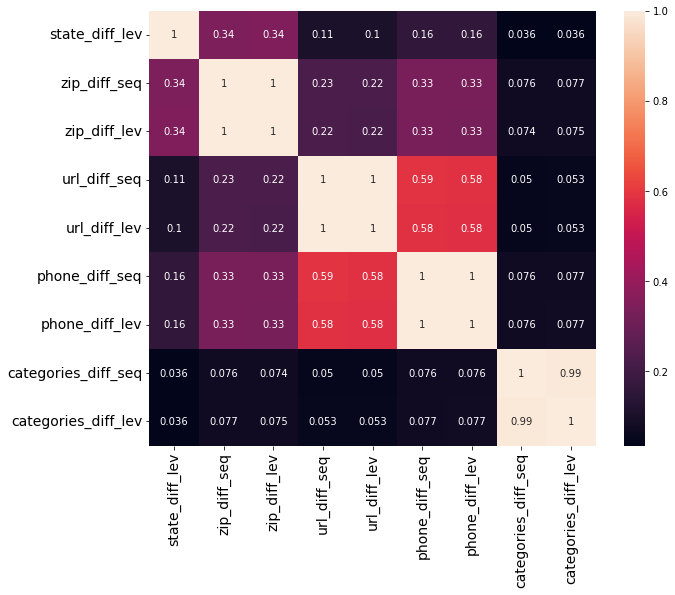

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df.iloc[:,-9:].corr(), annot=True, ax=ax)
ax.tick_params(axis='both',labelsize=14)
plt.show()

In [11]:
# Very slow using for loops!!!!! To be deleted!!!

# def get_sim(df,f1,f2,func):
#     '''Get similarity.
    
#     Get func() similarity/difference of selected feature
#     from data frame df. 
#     Return a list. 
    
#     '''
    
#     dist_arr = []
#     for i in range(len(df)):
#         a = df.iloc[[i]].loc[:,f1].values[0]
#         b = df.iloc[[i]].loc[:,f2].values[0]
#         d = func(a,b)
#         dist_arr.append(d)
#         if i%5000==0: 
#             print('{}; '.format(i), end='')
#         if i%50000==0:
#             print()
#     return dist_arr

# # geo similarity array;
# def l2_dist(a,b):
#     return np.linalg.norm(a-b)
# df['geo_sim'] = get_sim(df,f1 = ['latitude_1','longitude_1'],
#                            f2 = ['latitude_2','longitude_2'],
#                            func = l2_dist)

# # state similarity array;
# from difflib import SequenceMatcher
# def seq_matcher_sim(a,b):
#     return SequenceMatcher(None, a, b).ratio()

# df['state_sim'] = get_sim(df,f1 = ['state_1'],
#                              f2 = ['state_2'],
#                              func=seq_matcher_sim)

# # address similarity array;
# df['addr_sim'] = get_sim(df,f1 = ['address_1'],
#                             f2 = ['address_2'],
#                             func=seq_matcher_sim)

# # city similarity array;
# df['city_sim'] = get_sim(df,f1 = ['city_1'],
#                             f2 = ['city_2'],
#                             func=seq_matcher_sim)

# # zip similarity array;
# df['zip_sim'] = get_sim(df,f1 = ['zip_1'],
#                            f2 = ['zip_2'],
#                            func=seq_matcher_sim)

# # categories similarity array;
# df['cate_sim'] = get_sim(df,f1 = ['categories_1'],
#                             f2 = ['categories_2'],
#                             func=seq_matcher_sim)